# Jet tagging based on N-subjettiness

In [1]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('talk')

In [2]:
X = pd.read_csv('../data/signal_PU0_13TeV_MJ-65-95_PTJ-250-300_tau21.txt', delim_whitespace=True)
B = pd.read_csv('../data/backgr_PU0_13TeV_MJ-65-95_PTJ-250-300_tau21.txt', delim_whitespace=True)

In [3]:
y = np.concatenate((np.ones( X.shape[0], dtype='bool'), 
                    np.zeros(B.shape[0], dtype='bool')))

X = np.concatenate((X,B))

In [4]:
df = pd.DataFrame({'tau21':X.ravel(), 'y':y})
df.shape

(25094, 2)

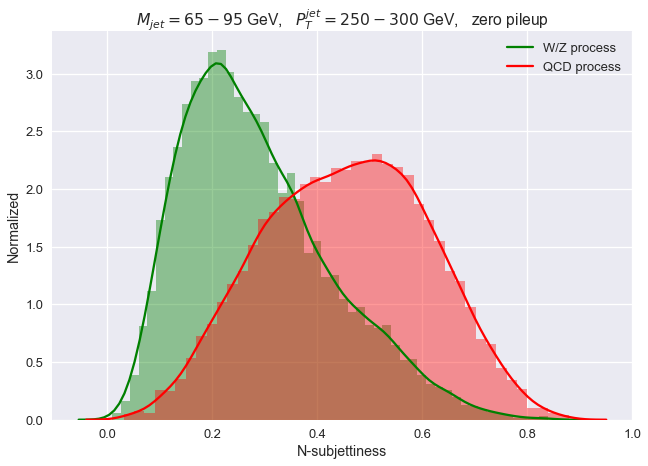

In [5]:
fig, ax = plt.subplots()

sns.distplot(df.query('y== True').tau21, kde=True, color='g', kde_kws={'label':'W/Z process'})
sns.distplot(df.query('y==False').tau21, kde=True, color='r', kde_kws={'label':'QCD process'})

ax.set_title('$M_{jet} = 65-95$ GeV,   $P_{T}^{jet} = 250-300$ GeV,   zero pileup')
ax.set_xlabel('N-subjettiness')
ax.set_ylabel('Normalized');

# Logistic Regression

In [6]:
from sklearn import linear_model
model = linear_model.LogisticRegression(random_state=12345)

model.fit(X,y);

In [7]:
X_test = np.linspace(0.,1.,50)
y_test = model.predict(X_test.reshape(-1,1))

sigmoid = lambda x: 1 / (1 + np.exp(-x))
loss = sigmoid(X_test * model.coef_ + model.intercept_).ravel()

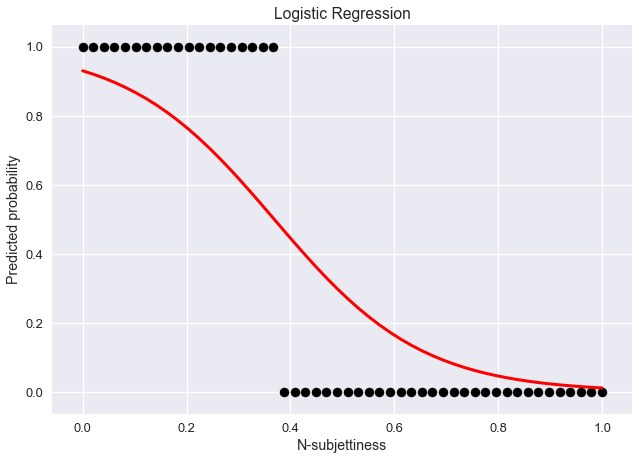

In [8]:
plt.scatter(X_test.ravel(), y_test, color='black')
plt.plot(X_test, loss, color='red', linewidth=3)
plt.xlabel('N-subjettiness')
plt.ylabel('Predicted probability')
plt.title('Logistic Regression')

In [9]:
-1 * model.intercept_ / model.coef_

array([[ 0.36898499]])

The logistic model classifies signal jets those with n-subjettiness $\tau_{21} < 0.369$. 

For this threshold, we have the rates:

In [10]:
def score_rates(threshold):
    TP = df.query("y== True & tau21<{}".format(threshold)).shape[0]
    FP = df.query("y== True & tau21>{}".format(threshold)).shape[0]
    TN = df.query("y==False & tau21>{}".format(threshold)).shape[0]
    FN = df.query("y==False & tau21<{}".format(threshold)).shape[0]
    TPR = TP / (TP + FN)
    FPR = FP / (FP + TN)
    return TPR, FPR

In [11]:
TPR, FPR = score_rates(0.36898)
#TPR, FPR = score_rates(0.85)

print("True (False) positives rate = {:.4f} ({:.4f})".format(TPR, FPR))

True (False) positives rate = 0.7105 (0.2717)


# Cross-validation

In [12]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(model, X, y, cv=5)

The mean score and the 95% confidence interval of the score estimate are given by:

In [13]:
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.72 (+/- 0.01)


In [14]:
import matplotlib.pyplot as plt
from scikitplot import classifier_factory

classifier_factory(model);

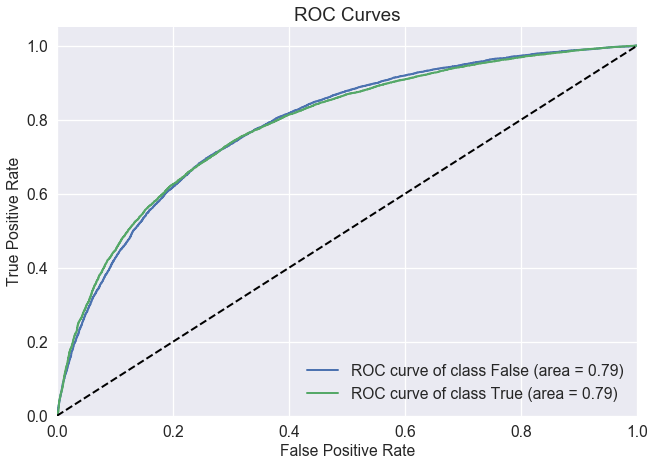

In [15]:
model.plot_roc_curve(X, y, random_state=12345, curves=(u'each_class'));